In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.x13 import x13_arima_analysis, x13_arima_select_order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.api import ARIMA

In [74]:
df = pd.read_csv("../data/raw_data.csv").rename(columns = {"DATE": "date", "Hard coal consumption per capita [tones]": "consumption"})
df.date = pd.to_datetime(df.date).dt.date

df

,date,consumption
0,1994-07-01,0.076
1,1994-08-01,0.097
2,1994-09-01,0.140
3,1994-10-01,0.213
4,1994-11-01,0.345
...,...,...
313,2020-08-01,0.005
314,2020-09-01,0.009
315,2020-10-01,0.028
316,2020-11-01,0.081


<AxesSubplot:title={'center':'Hard coal consumption per capita [tones]'}, xlabel='date'>

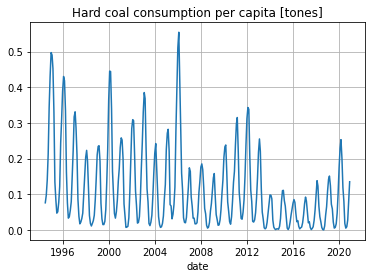

In [75]:
df.plot(x = "date", legend = False, title = "Hard coal consumption per capita [tones]", grid = True)

In [76]:
adfuller(df.consumption, maxlag=12)

(-4.150342523447282,
 0.0007987112476294385,
 12,
 305,
 {'1%': -3.451973573620699,
  '5%': -2.8710633193086648,
  '10%': -2.5718441306100512},
 -1441.0625563591223)

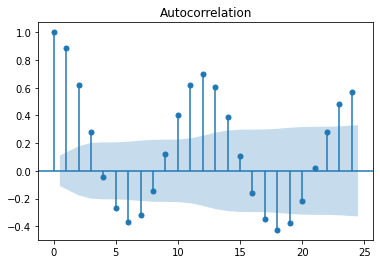

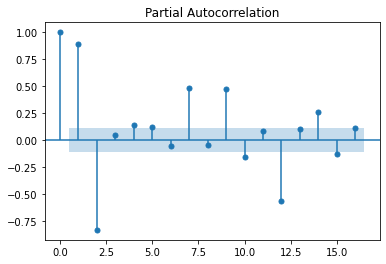

In [77]:
plot_acf(df.consumption, lags=24, alpha=.05, use_vlines=True)
plot_pacf(df.consumption, lags=16, alpha=.05, use_vlines=True)
print()

*Additive Moving Average seasonal decomposition*

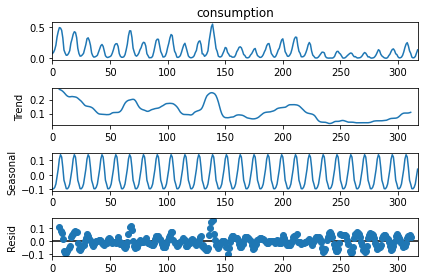

In [78]:
season_decomp_add = seasonal_decompose(df.consumption, model="additive", period=12)
season_decomp_add.plot()

df["resid_ma"] = season_decomp_add.resid.to_numpy()
df["sadj_ma"] = season_decomp_add.trend.to_numpy() + season_decomp_add.resid.to_numpy()

sadj_ma = df.sadj_ma.dropna().to_numpy()

In [79]:
adfuller(sadj_ma, maxlag=12)

(-3.1962994283800485,
 0.020199884571858527,
 6,
 299,
 {'1%': -3.4524113009049935,
  '5%': -2.8712554127251764,
  '10%': -2.571946570731871},
 -1455.991395513752)

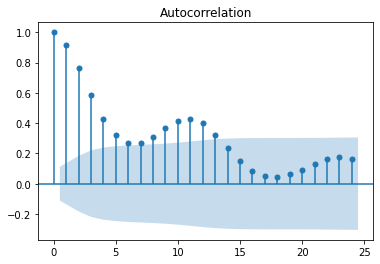

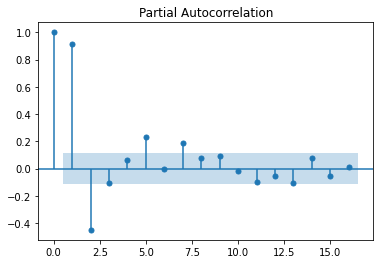

In [80]:
plot_acf(sadj_ma, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_ma, lags=16, alpha=.05, use_vlines=True)
print()

In [81]:
_, lbox_pval = acorr_ljungbox(sadj_ma, lags=12)
lbox_pval

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([5.39297667e-058, 8.28809638e-096, 7.77873612e-118, 5.12603484e-129,
       5.02218928e-135, 7.71851970e-139, 9.98782574e-143, 3.57896742e-148,
       3.00430606e-156, 4.60954016e-167, 1.19947114e-178, 1.31770509e-188])

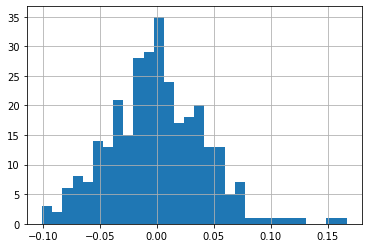

In [82]:
resid_ma = df.resid_ma.dropna().to_numpy()

plt.hist(resid_ma, bins=30)
plt.grid(True)

print()

*Multiplicative Moving Average seasonal decomposition*

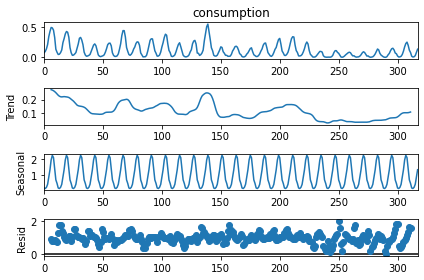

In [83]:
season_decomp_multi = seasonal_decompose(df.consumption + 1e-4, model="multiplicative", period=12)
season_decomp_multi.plot()

df["resid_ma_multi"] = season_decomp_multi.resid.to_numpy()
df["sadj_ma_multi"] = season_decomp_multi.trend.to_numpy() + season_decomp_multi.resid.to_numpy()

sadj_ma_multi = df.sadj_ma_multi.dropna().to_numpy()

In [84]:
adfuller(sadj_ma_multi, maxlag=12)

(-4.0567043918637555,
 0.0011410291312063034,
 12,
 293,
 {'1%': -3.452867117291862,
  '5%': -2.8714554160827745,
  '10%': -2.5720532321867466},
 -51.93188452547349)

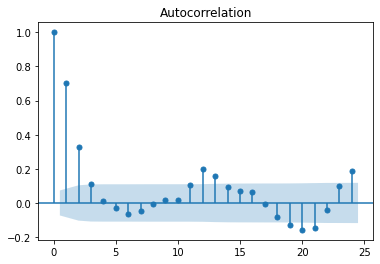

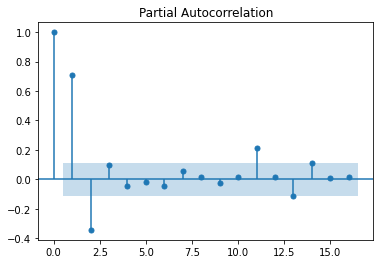

In [85]:
plot_acf(sadj_ma_multi, lags=24, alpha=.2, use_vlines=True)
plot_pacf(sadj_ma_multi, lags=16, alpha=.05, use_vlines=True)
print()

In [86]:
_, lbox_pval = acorr_ljungbox(sadj_ma_multi, lags=12)
lbox_pval

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([3.14034133e-35, 3.64882053e-41, 6.41234964e-41, 5.44982922e-40,
       3.43952208e-39, 1.23981376e-38, 5.10532366e-38, 2.77671505e-37,
       1.36593752e-36, 6.22257652e-36, 5.04658598e-36, 6.11589300e-38])

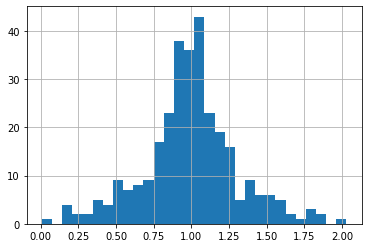

In [87]:
resid_ma_multi = df.resid_ma_multi.dropna().to_numpy()

plt.hist(resid_ma_multi, bins=30)
plt.grid(True)

print()

*STL decomposition*

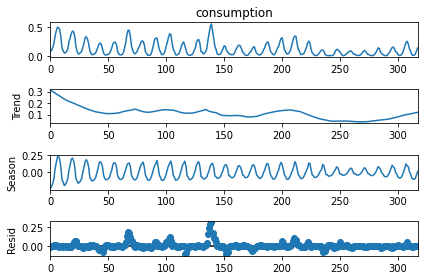

In [124]:
stl_decomp = STL(df.consumption, period=12, seasonal=7, robust=True).fit()
stl_decomp.plot()

df["resid_stl"] = stl_decomp.resid.to_numpy()

sadj_stl  = stl_decomp.trend.dropna().to_numpy() + stl_decomp.resid.dropna().to_numpy()

In [89]:
adfuller(sadj_stl, maxlag=12)

(-3.931280567986291,
 0.0018163270961775693,
 12,
 305,
 {'1%': -3.451973573620699,
  '5%': -2.8710633193086648,
  '10%': -2.5718441306100512},
 -1464.278191634505)

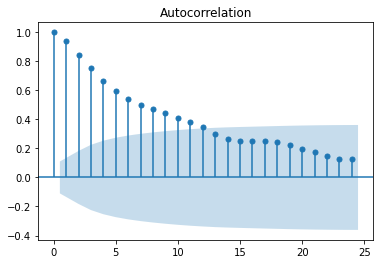

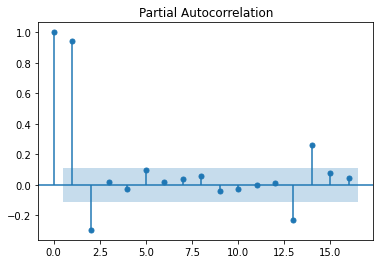

In [90]:
plot_acf(sadj_stl, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_stl, lags=16, alpha=.05, use_vlines=True)
print()

In [93]:
_, lbox_pval = acorr_ljungbox(sadj_stl, lags=12)
lbox_pval

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([2.93485086e-063, 9.75543520e-112, 4.95081654e-150, 9.04220550e-180,
       1.87582241e-203, 7.25994726e-223, 2.78977418e-239, 8.64705197e-254,
       1.35827155e-266, 1.35583380e-277, 7.54156243e-287, 1.52884874e-294])

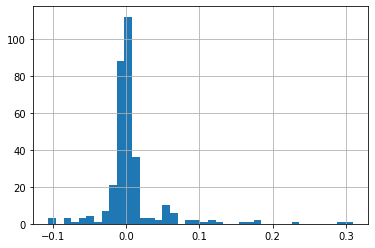

In [91]:
resid_stl = stl_decomp.resid.dropna().to_numpy()

plt.hist(resid_stl, bins=40)
plt.grid(True)

print()

In [92]:
qmin, qmax = np.quantile(resid_stl, q=[.03, .97])

df["outlier"] = (df.consumption.values < qmin) | (df.consumption.values > qmax)

df

,date,consumption,resid_ma,sadj_ma,resid_ma_multi,sadj_ma_multi,resid_stl,outlier
0,1994-07-01,0.076,NaN,NaN,NaN,NaN,-0.010635,False
1,1994-08-01,0.097,NaN,NaN,NaN,NaN,-0.004042,False
2,1994-09-01,0.140,NaN,NaN,NaN,NaN,-0.000269,True
3,1994-10-01,0.213,NaN,NaN,NaN,NaN,0.009103,True
4,1994-11-01,0.345,NaN,NaN,NaN,NaN,0.006853,True
...,...,...,...,...,...,...,...,...
313,2020-08-01,0.005,NaN,NaN,NaN,NaN,-0.007420,False
314,2020-09-01,0.009,NaN,NaN,NaN,NaN,-0.005023,False
315,2020-10-01,0.028,NaN,NaN,NaN,NaN,-0.001739,False
316,2020-11-01,0.081,NaN,NaN,NaN,NaN,0.004017,False


*Ensemble models: STL + ARIMA/ETS*

In [ ]:
stlf = STLForecast(df.consumption[0:306].to_numpy(), ARIMA, model_kwargs={"order": (2, 0, 0)}, period=12, seasonal=7, robust=True)
res = stlf.fit()

fcst = pd.Series(
    res.forecast(12),
    index=df.tail(12).date.values
)

plt.plot(df.date[250:], df.consumption[250:])
plt.plot(fcst)

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


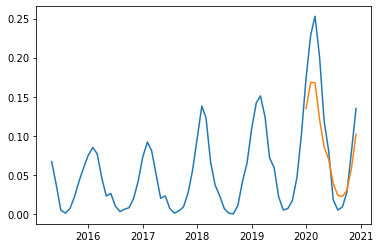

In [128]:
stlf = STLForecast(df.consumption[0:306].to_numpy(), SimpleExpSmoothing, period=12, seasonal=7, robust=True)
# stlf = STLForecast(df.consumption[0:306].to_numpy(), ARIMA, model_kwargs={"order": (2, 0, 0)}, period=12, seasonal=5, robust=True)
res = stlf.fit()

fcst = pd.Series(
    res.forecast(12),
    index=df.tail(12).date.values
)

plt.plot(df.date[250:], df.consumption[250:])
plt.plot(fcst)